In [1]:
import torch
import torch.nn as nn
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm

# Set device - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Solving the Ramsey model with deep learning

We use deep learning to solve the Ramsey model. We approximate the policy function $K'(K)$ by a neural network $f(K;\theta)$, such that this networks respects the Euler equation. 

Note that, since we are looking for a **policy function**, we are solving the model in the **state-space**. 

The algorithm is the following:

Initialize the network, then:
1. Draw some random state variables $K$
2. Using the current parameters of the network, evaluate the loss function, defined as the MSE of the Euler error 
3. Use gradient descent to improve the parameters of the network 
Iterate over steps 1-3 for X epochs.

As a reminder, the Euler equation in the Ramsey model writes
$u'(C)=\beta u'(C')(1+f'(K)-\delta)$ where $C+K'=f(K)+(1-\delta)K.$

## List of functions 

0. Some helper functions (production function, cash-on-hands, returns)
1. `DecisionNetwork` class: a class defining the structure of the network
2. `policy_function(K)`: normalizes inputs, evaluates the network, returns the savings rate 
3. `euler_residuals(K)`: computes the residual of the Euler equation 
4. `objective_function(n)`: returns the MSE of the Euler equations for `n` draws
5. `training_step()`: perform one training step 
6. `train(K)`: loop over training step for `K` iterations

## Model Parameters

We set some (common) values for the main parameters

In [2]:
## Preferences
beta = 0.9 
gamma = 2.0 

## Firms
alpha = 1/3 
delta = 0.05 

Define some helpful equations.

In [3]:
def production_function(K):
    """Cobb-Douglas production function"""
    return K**alpha 

def coh_fun(K):
    return production_function(K) + (1 - delta) * K

def r_fun(K):
    """Return the interest rate given Z and K"""
    return alpha * production_function(K) / K - delta 

def c_fun(savings_rate, K):
    """Consumption function given savings rate, TFP Z and capital K"""
    coh = coh_fun(K)
    return (1 - savings_rate) * coh


In [4]:
# Steady-state 
r = 1/beta - 1 
K_ss = ((r + delta) / (alpha))**(1/(alpha-1))
Y_ss = K_ss**alpha
C_ss = Y_ss - delta * K_ss 
savings_rate_ss = K_ss / (Y_ss + (1 - delta) * K_ss)

# bounds for endogenous state variable
Kmin = K_ss * 0.5
Kmax = K_ss * 2.5
K_grid = np.linspace(Kmin, Kmax, 500)

## Neural Network Definition


In [ ]:
class DecisionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), # one input
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1) # one output
        )
    
    def forward(self, x):
        return self.net(x)

network = DecisionNetwork().to(device)

In [6]:
def policy_function(K):
    """Decision rule: maps states to savings rate"""
    
    # Normalize inputs to roughly [-1, 1] range
    K_normalized = 2.0 * (K - Kmin) / (Kmax - Kmin) - 1.0
    
    # Stack inputs: shape (n, 1)
    s = torch.stack([K_normalized], dim=1)
    
    # Forward pass through network
    x = network(s)  # (n, 1)
    
    # Savings rate in [0,1]
    savings_rate = torch.sigmoid(x[:, 0])
        
    return torch.clamp(savings_rate, min = 0.1, max = 0.9999)

## Euler residual

In [7]:
def euler_residuals(K):
    # Current decisions
    savings_rate = policy_function(K)
    coh = coh_fun(K)
    C = c_fun(savings_rate, K)
    K_next = savings_rate * coh

    # LHS: u'(C)
    LHS = C**(-gamma)

    # Next-period policy and consumption
    savings_rate_next = policy_function(K_next)
    C_next = c_fun(savings_rate_next, K_next)

    # Future returns and marginal utility
    r_next = r_fun(K_next)
    MU_next = C_next**(-gamma)
    RHS = beta * MU_next * (1.0 + r_next)

    # Residual
    R = RHS / LHS - 1.0
    return R


## Objective Function 

In [8]:
def objective_function(n):
    K = torch.rand(n, device=device) * (Kmax - Kmin) + Kmin
    R = euler_residuals(K)
    R_squared = R**2
    return torch.mean(R_squared)

In [9]:
n = 128
v = objective_function(n)
print(f"Initial objective value: {v.item():.6f}")

Initial objective value: 0.357018


## Training Loop

In [ ]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-5)

def training_step():
    optimizer.zero_grad() # reinitialize gradients
    loss = objective_function(n) # compute loss
    loss.backward() # compute the gradients
    optimizer.step() # update parameters
    return loss.item()

def train(X):
    vals = []
    for k in tqdm(range(X)):
        val = training_step()
        vals.append(val)
    return vals

In [11]:
results = train(50_000)

100%|██████████| 50000/50000 [00:21<00:00, 2362.17it/s]


## Training Convergence

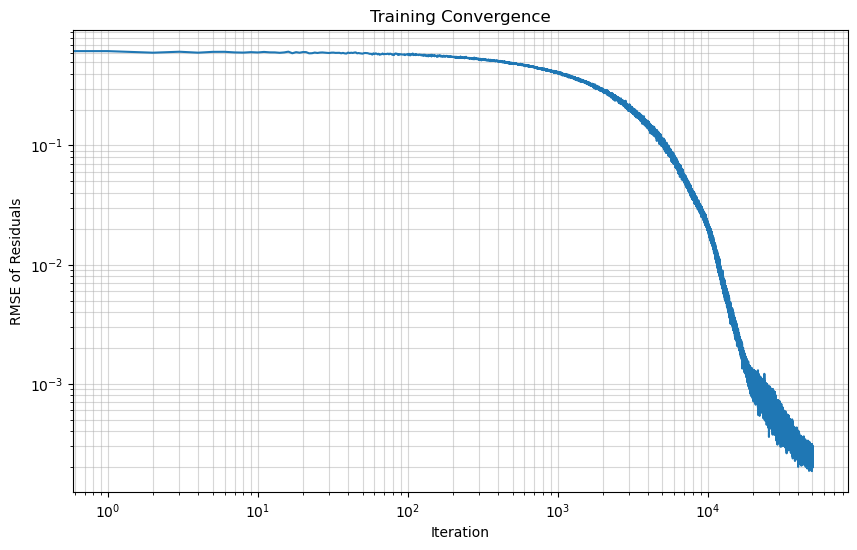

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(np.abs(results)))  # abs() for numerical safety
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('RMSE of Residuals')
plt.title('Training Convergence')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

In [13]:
euler_residuals(torch.tensor([K_ss], device=device))

tensor([8.1182e-05], grad_fn=<SubBackward0>)

In [14]:
print(policy_function(torch.tensor([K_ss], device=device)))
print(savings_rate_ss)

tensor([0.6976], grad_fn=<ClampBackward1>)
0.6976744186046512


## Compare Deep Learning vs VFI

In [16]:
from ramsey_vfi import vfi, extract_policies, K_grid

_, policy_K = vfi(tol = 1e-6, max_iter = 1000, verbose = True)
policy_C, policy_s = extract_policies(policy_K)

Iteration 1: max value function diff = 0.60817707
Iteration 2: max value function diff = 0.34805745
Iteration 3: max value function diff = 0.21199251
Iteration 4: max value function diff = 0.13349623
Iteration 5: max value function diff = 0.10094396
Iteration 6: max value function diff = 0.08885811
Iteration 7: max value function diff = 0.07803050
Iteration 8: max value function diff = 0.06839027
Iteration 9: max value function diff = 0.05989939
Iteration 10: max value function diff = 0.05246106
Iteration 11: max value function diff = 0.04592356
Iteration 12: max value function diff = 0.04024436
Iteration 13: max value function diff = 0.03528818
Iteration 14: max value function diff = 0.03097188
Iteration 15: max value function diff = 0.02721836
Iteration 16: max value function diff = 0.02395545
Iteration 17: max value function diff = 0.02111083
Iteration 18: max value function diff = 0.01862428
Iteration 19: max value function diff = 0.01645292
Iteration 20: max value function diff = 

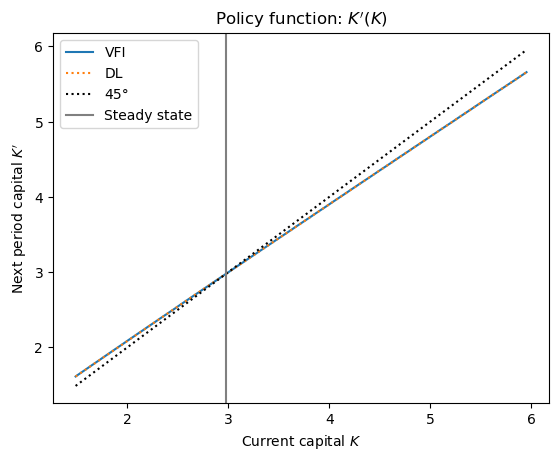

In [21]:
coh = coh_fun(K_grid)
s = policy_function(torch.tensor([K_grid], dtype = torch.float32)[0]).detach().numpy() 
K_next_dl = coh * s 

plt.plot(K_grid, policy_K , label = 'VFI')
plt.plot(K_grid, K_next_dl, label = 'DL', linestyle = ':')
plt.plot(K_grid, K_grid, color = 'black', linestyle = ':', label = '45°')
plt.axvline(x = K_ss, color = 'grey', label = 'Steady state')
plt.title("Policy function: $K'(K)$")
plt.xlabel("Current capital $K$")
plt.ylabel("Next period capital $K'$")
plt.legend()
plt.show()

In [22]:
# Diagnostics: check K' bounds vs VFI constraints
K_tensor = torch.tensor(K_grid, dtype=torch.float32, device=device)
s_dl = policy_function(K_tensor).detach().cpu().numpy()
coh = coh_fun(K_grid)
K_next_dl = coh * s_dl
print("K_min:", Kmin, "K_max:", Kmax)
print("K_next_dl min/max:", K_next_dl.min(), K_next_dl.max())
print("Violations below K_min:", (K_next_dl < Kmin).sum())
print("Violations above K_max:", (K_next_dl > Kmax).sum())
print("Min (coh - K_next_dl):", (coh - K_next_dl).min())

K_min: 1.48798955633395 K_max: 7.43994778166975
K_next_dl min/max: 1.613536560473075 5.655768176566058
Violations below K_min: 0
Violations above K_max: 0
Min (coh - K_next_dl): 0.9417043417812447
